In [1]:
import pyedflib
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import stats
from scipy.fft import rfft, rfftfreq, irfft
from scipy.signal import butter, filtfilt, find_peaks
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.annotation.clasp import ClaSPSegmentation, find_dominant_window_sizes
from sktime.annotation.plotting.utils import (
    plot_time_series_with_change_points,
    plot_time_series_with_profiles,
)
from sktime.utils.plotting import plot_series
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
#from tqdm.notebook import tqdm
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
# Игнорировать все предупреждения
warnings.filterwarnings("ignore")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


libgomp: Invalid value for environment variable OMP_NUM_THREADS


# Extract features

Сохраним сегменты временных рядов для дальнейшего их анализа и сравнения

In [ ]:
path = Path("/home/jovyan/denisova/hacks/cp meznar/data/golden")

for file_name in tqdm(path.rglob("*")):
    file_name = str(file_name)
    if 'Ati4y3_12m_BL_6h_edited' not in str(file_name):
        f = pyedflib.EdfReader(file_name)
        n = f.signals_in_file
        n_a = f.annotations_in_file
        signal_labels = f.getSignalLabels()

        sigbufs = np.zeros((n, f.getNSamples()[0]))
        count = 0

        for i in np.arange(n):
            sigbufs[i, :] = f.readSignal(i)

        annotations = list(f.readAnnotations())
        annotations[0] = annotations[0] / (f.getFileDuration() / sigbufs.shape[1])

        for i in range(0, len(annotations[0]), 2):
            result = sigbufs[:, int(annotations[0][i]):int(annotations[0][i + 1])]
            name = file_name.split('/')[-1][:-4] + f'_{annotations[2][i]}_{annotations[2][i + 1]}_{count}'
            np.save(f'/home/jovyan/denisova/hacks/cp meznar/data/segments/{name}.npy', result)
            count += 1

Разделим 6-часовые записи на более мелкие промежутки (окна) и будем работать и анализировать эти окна

In [2]:
def filter_swd(input_array):
    unique_elements = set(input_array)
    result_array = []
    pairs = {
        'swd1': 'swd2',
        'swd2': 'swd1',
        'is1': 'is2',
        'is2': 'is1',
        'ds1': 'ds2',
        'ds2': 'ds1'
    }

    if input_array[0] in pairs:
        if pairs[input_array[0]] != input_array[1]:
            result_array.append(0)

    for i in range (1, len(input_array)-1):
        if input_array[i] in pairs:
            if pairs[input_array[i]] != input_array[i+1] and pairs[input_array[i]] != input_array[i-1]:
                result_array.append(i)

    n = len(input_array)
    if input_array[n-1] in pairs:
        if pairs[input_array[n-1]] != input_array[n-2]:
            result_array.append(n-1)
            
    for i in range(1, len(input_array)):
        if input_array[i] == input_array[i-1]:
            result_array.append(i)
    
    
    return result_array

In [ ]:
path = Path("/home/jovyan/denisova/hacks/cp meznar/data/fully")
results = pd.DataFrame({'emb': [], 'label': []})

for file_name in path.rglob("*"):
    file_name = str(file_name)
    if 'Ati4y3_12m_BL_6h_edited' not in str(file_name):
        f = pyedflib.EdfReader(file_name)
        n = f.signals_in_file
        n_a = f.annotations_in_file
        signal_labels = f.getSignalLabels()

        sigbufs = np.zeros((n, f.getNSamples()[0]))

        for i in np.arange(n):
            sigbufs[i, :] = f.readSignal(i)

        annotations = list(f.readAnnotations())
        annotations[0] = annotations[0] / (f.getFileDuration() / sigbufs.shape[1])
        
        indexes = filter_swd(annotations[2])
        annotations = np.delete(annotations, indexes, axis=1)
        ground_trouth = np.array(['none'] * sigbufs.shape[1])

        for j in range(0, len(annotations[0]), 2):
            ground_trouth[int(str(annotations[0][j]).split('.')[0]): int(str(annotations[0][j + 1]).split('.')[0])+1] = annotations[2][j][:-1]
        
        
        for i in tqdm(range(0, sigbufs.shape[1], 100)):
            if i + 1000 < sigbufs.shape[1]:
                result = sigbufs[:, i:i+1000]
                    
                results = results.append({'emb': result, 'label': ground_trouth[i+999]}, ignore_index=True)

  5%|▌         | 4731/86404 [00:36<10:13, 133.08it/s]

In [ ]:
results

In [ ]:
results['emb'] = results['emb'].map(lambda x: x.reshape(-1))
results.to_parquet('data.parquet')

In [ ]:
results['label'].value_counts().plot(kind='bar')

# Predprocessing

In [ ]:
file_name = 'golden/Ati4x1_15m_H2O_6h_edited.edf'
f = pyedflib.EdfReader(file_name)
n = f.signals_in_file
n_a = f.annotations_in_file
signal_labels = f.getSignalLabels()
sigbufs = np.zeros((n, f.getNSamples()[0]))

for i in np.arange(n):
    sigbufs[i, :] = f.readSignal(i)

In [ ]:
annotations = list(f.readAnnotations())
annotations[0] = annotations[0] / (f.getFileDuration() / sigbufs.shape[1])
annotations

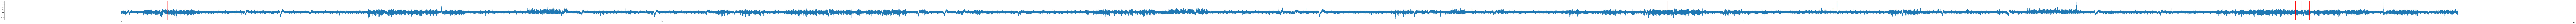

In [34]:
fig, ax = plt.subplots(figsize=(400, 3))
sns.lineplot(ax=ax, y=sigbufs[0], x=np.arange(8640400))

for i in annotations[0]:
    plt.axvline(i, min(sigbufs[0]), max(sigbufs[0]) + 1, color='red')

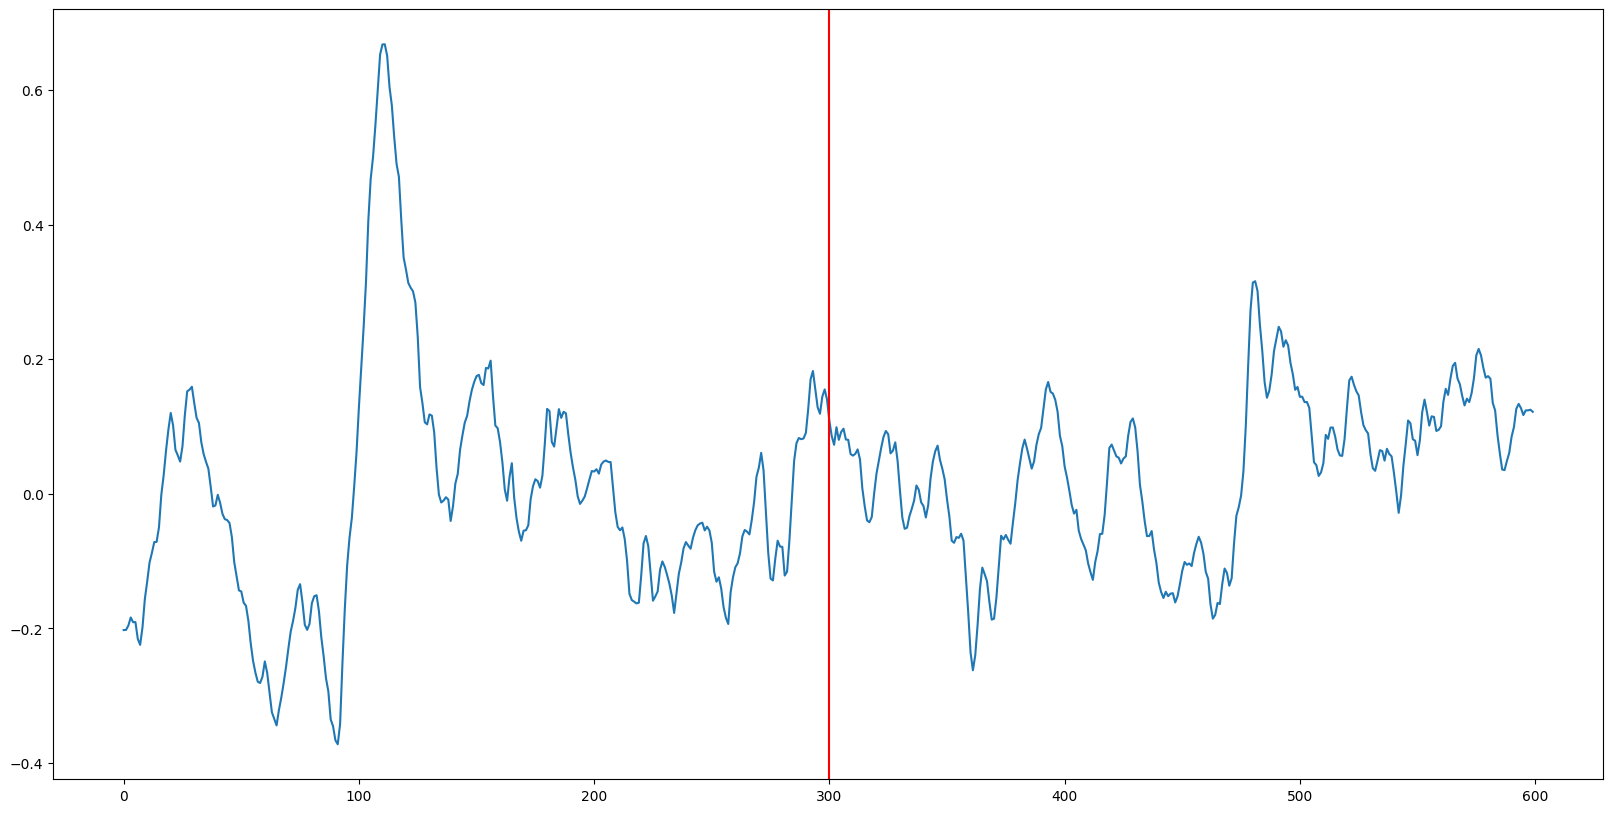

In [51]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(ax=ax, y=sigbufs[0, 171400-300:171400+300], x=np.arange(600))
plt.axvline(300, min(sigbufs[0]), max(sigbufs[0]) + 1, color='red')

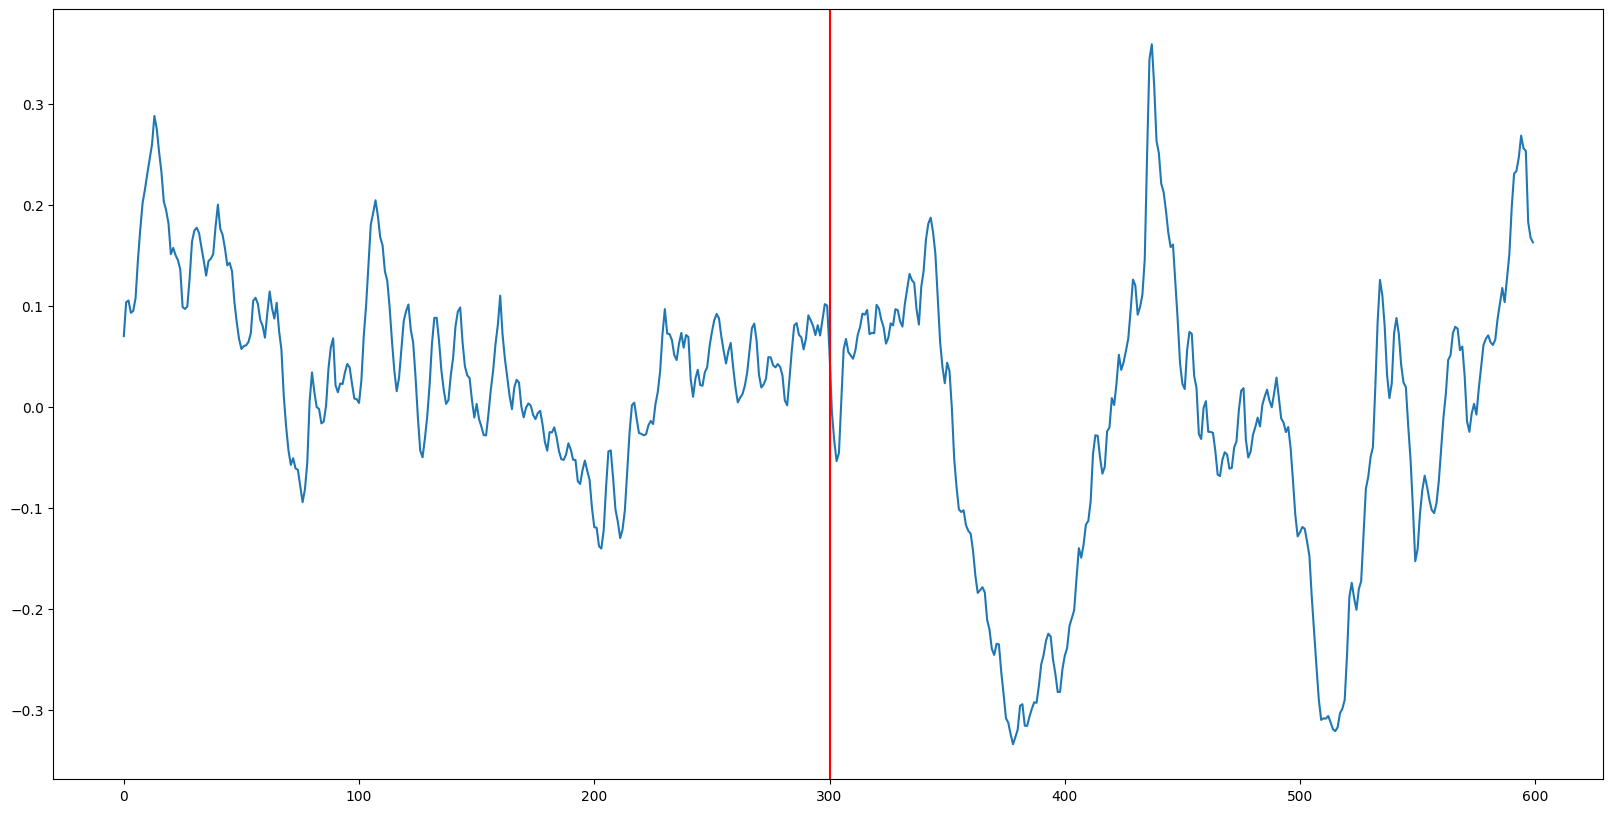

In [52]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(ax=ax, y=sigbufs[0, 184180-300:184180+300], x=np.arange(600))
plt.axvline(300, min(sigbufs[0]), max(sigbufs[0]) + 1, color='red')

In [42]:
def remove_anomalies_moving_average(data, window_size=10000, threshold=2):
    rolling_mean = data.rolling(window=window_size).mean()
    rolling_std = data.rolling(window=window_size).std()
    anomalies = (data - rolling_mean).abs() > threshold * rolling_std
    return data[~anomalies]

In [43]:
cleaned_data = remove_anomalies_moving_average(pd.Series(sigbufs[0]))

In [44]:
len(cleaned_data)

8143183

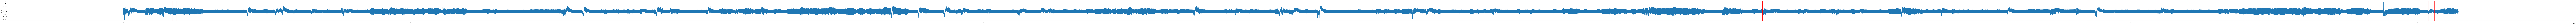

In [45]:
fig, ax = plt.subplots(figsize=(400, 3))
sns.lineplot(ax=ax, y=cleaned_data, x=np.arange(len(cleaned_data)))

for i in annotations[0]:
    plt.axvline(i, min(cleaned_data), max(cleaned_data) + 1, color='red')

# Clustering

In [10]:
prep = MaxAbsScaler()
kmeans = KMeans(n_clusters=15, random_state=0)

In [14]:
scaled_data = prep.fit_transform(pd.DataFrame(sigbufs.reshape((-1, 3))))
kmeans.fit(scaled_data)

/home/user/conda/envs/hacks/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=15, random_state=0)

<Axes: >

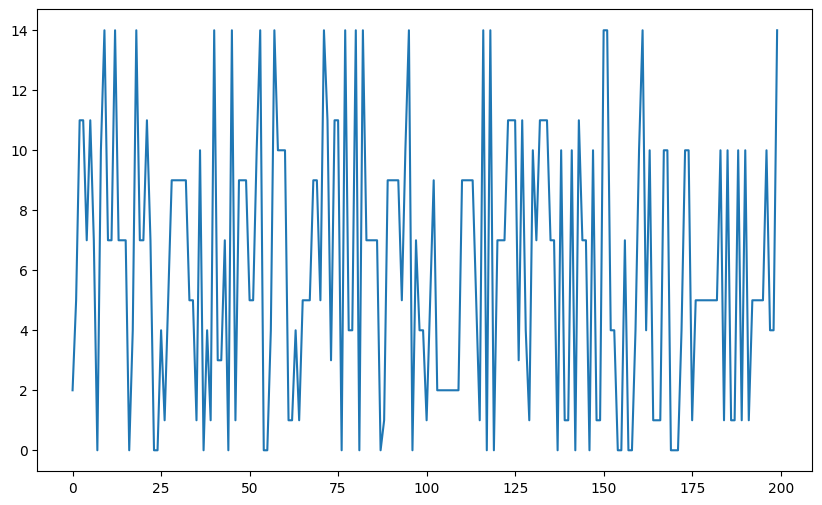

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(ax=ax, y=kmeans.labels_[:200], x=np.arange(len(kmeans.labels_[:200])))

In [3]:
sigbufs.shape

(3, 8640400)

# Segmentation

In [33]:
def moving_average(series, n):
    return np.average(series[-n:])

<Axes: >

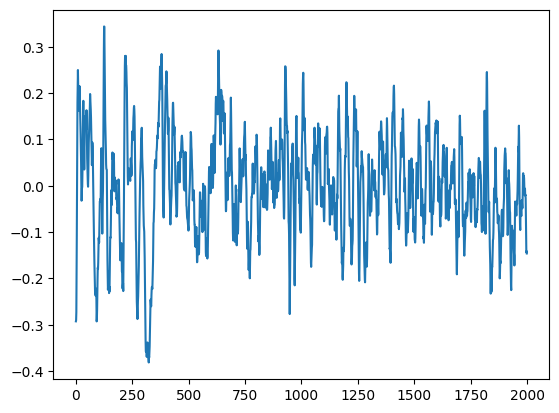

In [32]:
sns.lineplot(y=sigbufs[0, 0:2000], x=np.arange(2000))

In [ ]:
pred = sigbufs[0, ]

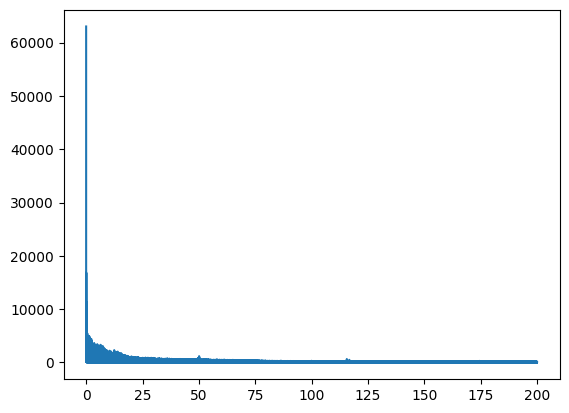

In [105]:
yf = rfft(sigbufs[0])
xf = rfftfreq(len(sigbufs[0]), 1 / 400)

plt.plot(xf, np.abs(yf))

In [110]:
points_per_freq = len(xf) / (256 / 2)

# Наша целевая частота - 4000 Гц
target_idx = int(points_per_freq / 25)

In [112]:
target_idx

1350

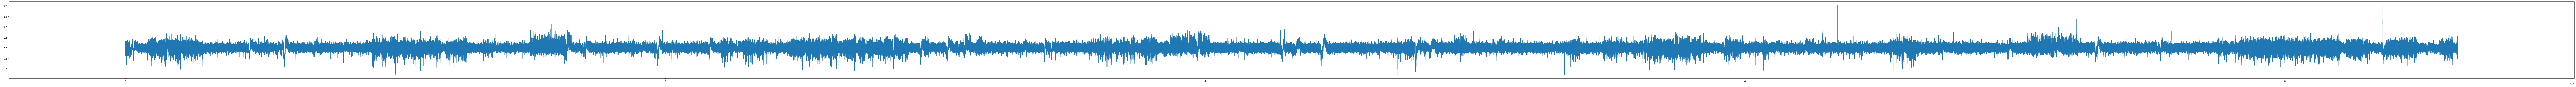

In [111]:
yf[target_idx-2:target_idx+2] = 0
new_sig = irfft(yf)

fig, ax = plt.subplots(figsize=(200, 6))
plt.plot(new_sig)
plt.show()

In [91]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [92]:
filtered_signal = bandpass_filter(sigbufs[0, start:end], 0.5, 30, 256)

In [93]:
filtered_signal

array([ 0.08305761,  0.03809283,  0.00551183, ...,  0.01549863,
       -0.00994298, -0.0429144 ])

<Axes: >

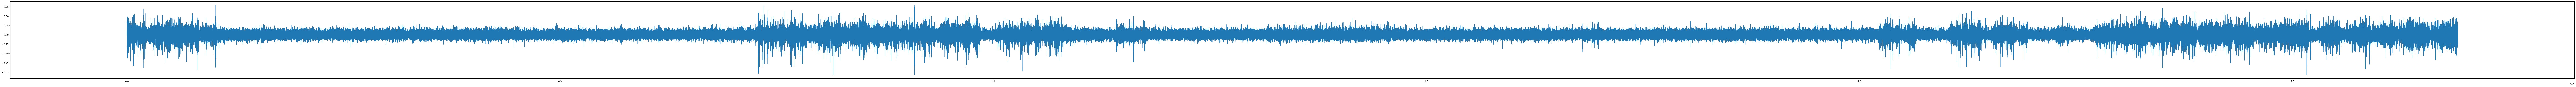

In [96]:
fig, ax = plt.subplots(figsize=(200, 6))
sns.lineplot(ax=ax, y=filtered_signal, x=np.arange(end-start))

In [63]:
fluctuation.shift(400)

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
          ... 
2698115    1.0
2698116    1.0
2698117    1.0
2698118    1.0
2698119    1.0
Length: 2698120, dtype: float64

In [67]:
1 / 0.0025

400.0

In [64]:
fluctuation

0          0
1          0
2          0
3          0
4          0
          ..
2698115   -1
2698116   -1
2698117   -1
2698118   -1
2698119   -1
Length: 2698120, dtype: int64

In [71]:
diff = data.diff()

# Определяем колебания: считаем, когда разность меняет знак
fluctuation = pd.Series(np.where(diff > 0, 1, np.where(diff < 0, -1, 0)))

# Считаем количество колебаний
fluctuation_count = fluctuation[start:start+400].ne(fluctuation[start:start+400].shift()).sum()
fluctuation_count

17

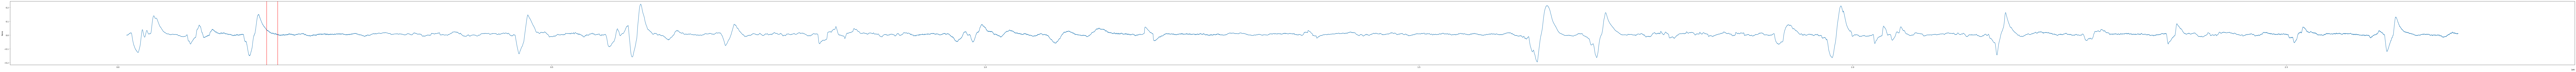

In [73]:
data = pd.Series(sigbufs[0, :2698120]).rolling(window=10000).mean()
fig, ax = plt.subplots(figsize=(240, 6))
sns.lineplot(ax=ax, y=data, x=np.arange(2698120))
plt.axvline(start, min(sigbufs[0, :2698120]), max(sigbufs[0, :2698120]) + 1, color='red')
plt.axvline(end, min(sigbufs[0, :2698120]), max(sigbufs[0, :2698120]) + 1, color='red')

/home/user/conda/envs/hacks/lib/python3.9/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

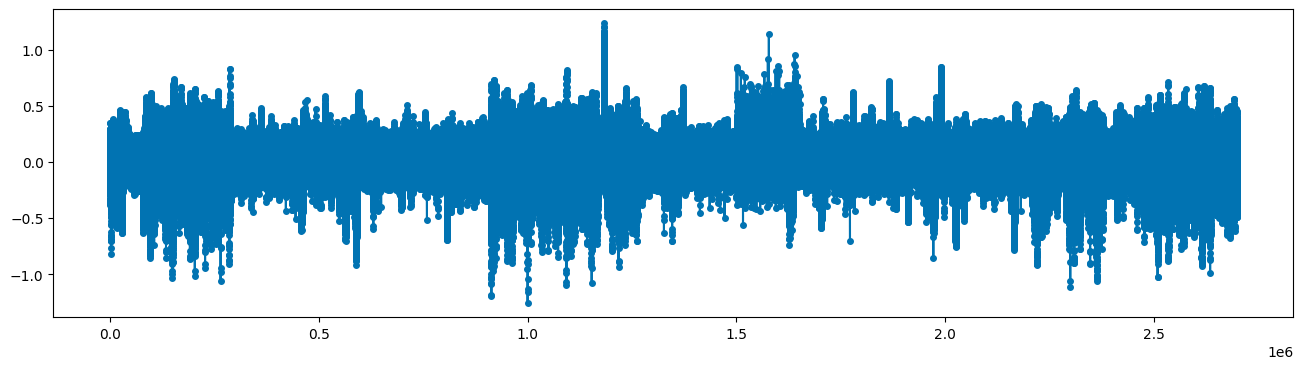

In [16]:
plot_series(pd.Series(sigbufs[0, :2698120]))

In [46]:
seasonal_result = seasonal_decompose(data.dropna(), period=10000)

trend = seasonal_result.trend
resid = seasonal_result.resid
seasonal = seasonal_result.seasonal

In [55]:
data[1000:]

1000       0.003563
1001       0.003905
1002       0.004265
1003       0.004573
1004       0.004803
             ...   
2698115    0.009627
2698116    0.009862
2698117    0.010082
2698118    0.010259
2698119    0.010399
Length: 2697120, dtype: float64

In [50]:
seasonal

999        0.000799
1000       0.000814
1001       0.000827
1002       0.000839
1003       0.000851
             ...   
2698115    0.000337
2698116    0.000340
2698117    0.000338
2698118    0.000333
2698119    0.000325
Name: seasonal, Length: 2697121, dtype: float64

In [ ]:
fig, ax = plt.subplots(figsize=(240, 6))
sns.lineplot(ax=ax, y=resid+seasonal, x=np.arange(2698120))
plt.axvline(start, min(sigbufs[0, :2698120]), max(sigbufs[0, :2698120]) + 1, color='red')
plt.axvline(end, min(sigbufs[0, :2698120]), max(sigbufs[0, :2698120]) + 1, color='red')

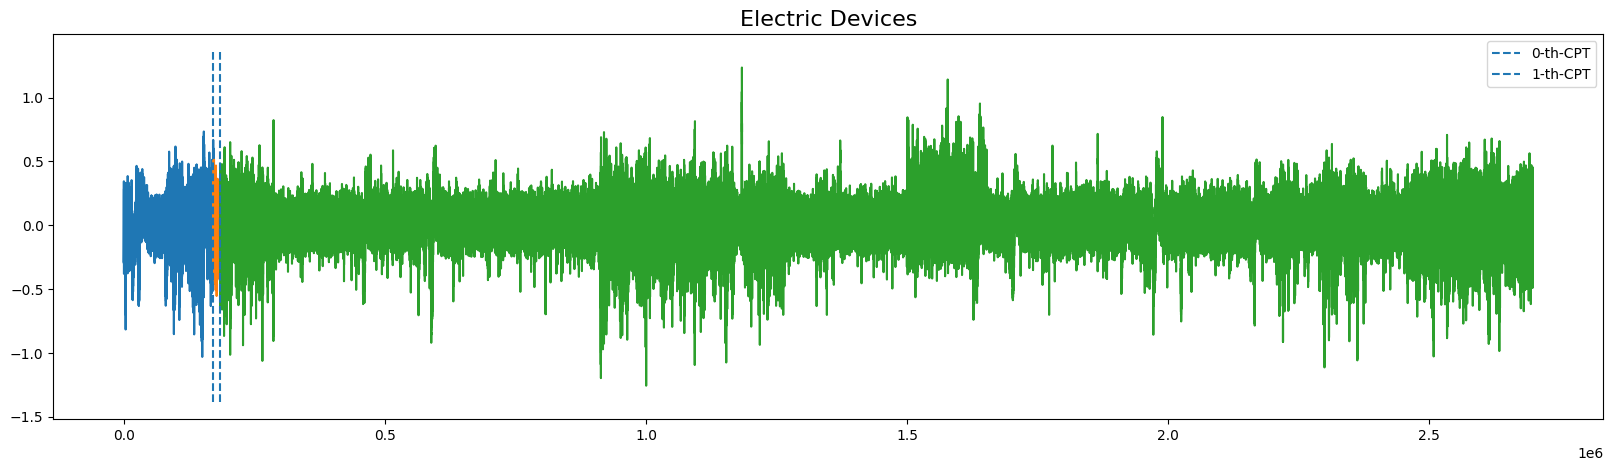

In [10]:
_ = plot_time_series_with_change_points("Electric Devices", pd.Series(sigbufs[0, :2698120]), [171400,  184180])

In [12]:
clasp = ClaSPSegmentation(period_length=100000, n_cps=2)
found_cps = clasp.fit_predict(pd.Series(sigbufs[0, :2698120]))
profiles = clasp.profiles
scores = clasp.scores
print("The found change points are", found_cps.to_numpy())

/home/user/conda/envs/hacks/lib/python3.9/site-packages/numba/core/config.py:213: RuntimeWarning: Environment variable 'NUMBA_NUM_THREADS' is defined but its associated value '' could not be parsed.
The parse failed with exception:
Traceback (most recent call last):
  File "/home/user/conda/envs/hacks/lib/python3.9/site-packages/numba/core/config.py", line 211, in _readenv
    return ctor(value)
ValueError: invalid literal for int() with base 10: ''

  warnings.warn(f"Environment variable '{name}' is defined but "


KeyboardInterrupt: 

In [ ]:
_ = plot_time_series_with_profiles(
    "Electric Devices",
    pd.Series(sigbufs[0, :2698120]),
    profiles,
    [171400,  184180],
    found_cps,
)

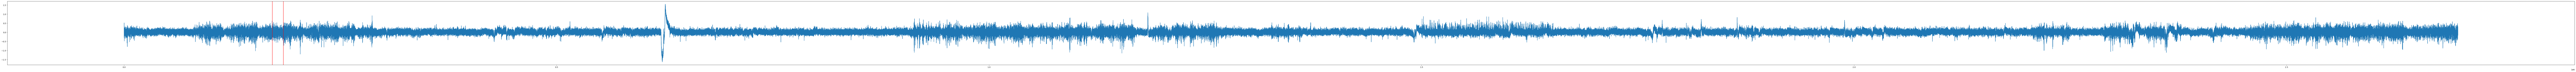

In [6]:
fig, ax = plt.subplots(figsize=(240, 6))
sns.lineplot(ax=ax, y=sigbufs[1, :2698120], x=np.arange(2698120))
plt.axvline(start, min(sigbufs[1, :2698120]), max(sigbufs[1, :2698120]) + 1, color='red')
plt.axvline(end, min(sigbufs[1, :2698120]), max(sigbufs[1, :2698120]) + 1, color='red')

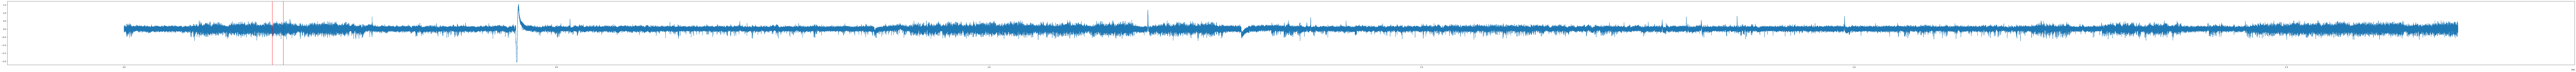

In [7]:
fig, ax = plt.subplots(figsize=(240, 6))
sns.lineplot(ax=ax, y=sigbufs[2, :2698120], x=np.arange(2698120))
plt.axvline(start, min(sigbufs[2, :2698120]), max(sigbufs[2, :2698120]) + 1, color='red')
plt.axvline(end, min(sigbufs[2, :2698120]), max(sigbufs[2, :2698120]) + 1, color='red')